In [1]:
import pandas as pd
import torch
import torchrec

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

/tmp/ipykernel_28942/3436774584.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/shizhe/miniconda3/envs/rec/lib/python3.11/site-packages/torchrec/sparse/jagged_tensor.py:588: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _register_pytree_node(JaggedTensor, _jt_flatten, _jt_unflatten)
/home/shizhe/miniconda3/envs/rec/lib/python3.11/site-packages/torchrec/sparse/jagged_tensor.py:1993: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node i

# loading data

In [21]:
info = pd.read_csv('dataset/ml-100k/u.info' , names=['Counts' , 'Type'], sep=" ", header = None)
info.to_csv('dataset/ml-100k/info.csv')
info

,Counts,Type
0,943,users
1,1682,items
2,100000,ratings


In [22]:
occupation = pd.read_csv('dataset/ml-100k/u.occupation', names=['Occupation'], header = None)
occupation.to_csv('dataset/ml-100k/occupation.csv')
occupation

,Occupation
0,administrator
1,artist
2,doctor
3,educator
4,engineer
5,entertainment
6,executive
7,healthcare
8,homemaker
9,lawyer


In [23]:
items = pd.read_csv('dataset/ml-100k/u.item' , header = None , sep = "|" , encoding='latin-1')
items.columns = ['movie_id' , 'movie_title' , 'release_date' , 'video_release_date' ,
              'IMDb_URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              'Childrens' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film_Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci_Fi' ,
              'Thriller' , 'War' , 'Western']
items.to_csv('dataset/ml-100k/item.csv')
items.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:
user = pd.read_csv('dataset/ml-100k/u.user', names=['user_id' , 'age' , 'gender' , 'occupation' , 'zipcode'],
                   header= None , sep = '|')
user.to_csv('dataset/ml-100k/user.csv')
user

,user_id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [25]:
genre = pd.read_csv('dataset/ml-100k/u.genre', names=['Genre' , 'genre_id'], header= None , sep = '|' )
genre.to_csv('dataset/ml-100k/genre.csv')
genre

,Genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


In [26]:
data = pd.read_csv('dataset/ml-100k/u.data', names=['user_id', 'item_id', 'rating', 'timestamp'], header= None , sep = '\t')
data.to_csv('dataset/ml-100k/data.csv')
data

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


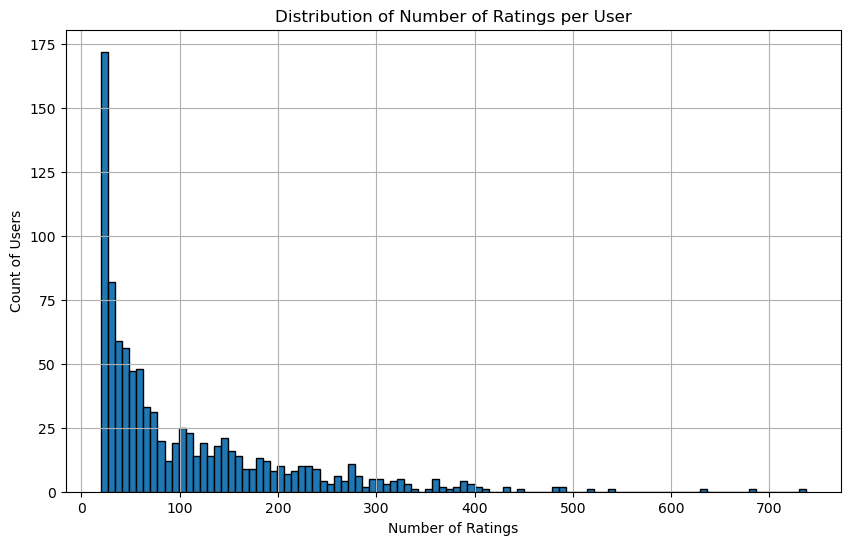

In [11]:
ratings_per_user = data.groupby('user_id').size()

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
ratings_per_user.hist(bins=100, edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()


In [14]:
ratings_per_user.sort_values()

user_id
202     20
441     20
685     20
34      20
36      20
      ... 
276    518
450    540
13     636
655    685
405    737
Length: 943, dtype: int64

[(474, 4.35728057902336),
 (732, 3.647398554815309),
 (318, 3.64635876435068),
 (568, 3.448769049590842),
 (655, 3.445490587368326),
 (527, 3.341147001603023),
 (423, 3.338077638524084),
 (566, 3.250002555477586),
 (433, 3.248985543886195),
 (403, 3.1352762062250488)]